<a href="https://colab.research.google.com/github/piyushsrivastav/Medical-issues/blob/main/Brain_MRI_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brain Tumor MRI Scans

### Image segmentation problem using Transfer Learning 



### Context: 
A brain tumor is a collection, or mass, of abnormal cells in your brain. Your skull, which encloses your brain, is very rigid. Any growth inside such a restricted space can cause problems. Brain tumors can be cancerous (malignant) or noncancerous (benign). When benign or malignant tumors grow, they can cause the pressure inside your skull to increase. This can cause brain damage, and it can be life-threatening.

Early detection and classification of brain tumors is an important research domain in the field of medical imaging and accordingly helps in selecting the most convenient treatment method to save patients life therefore.

### Objective:
The goal is to build a robust Deep learning model that is in context to improve health diagnosis for providing impactful solutions. Proper brain tumor diagnosis involves detection, brain tumor location identification, and classification of the tumor on the basis of malignancy, grade, and type.

### Dataset Description:
This dataset contains 7022 images of human brain MRI images which are classified into 4 classes:
- glioma 
- meningioma 
- no tumor 
- pituitary.



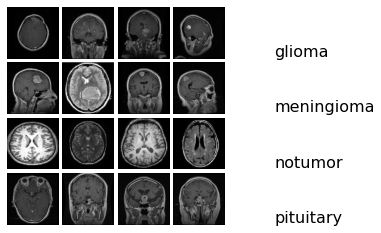

### Dataset Source: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset

In [ ]:
# Import required libraries

# Initialize the random number generator
import random
random.seed(0)

# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow
tensorflow.__version__

'2.8.2'

In [ ]:
## Mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Set the appropriate path for the datsaet zip provided**

In [ ]:
images_path="/content/drive/MyDrive/Brain_tumor_data.zip"

**Extracting the dataset.zip to the present working directory**

In [ ]:
from zipfile import ZipFile
with ZipFile(images_path, 'r') as z:
  z.extractall()

### Data Visualization- Dataset has test and train folder

In [ ]:
# Extracting the testing images and storing it in a dataframe for visualization purpose
import os
import cv2

file_path = '/content/Brain_tumor_data/Testing'  
df = pd.DataFrame(columns=['file_name','class','image'])
for i in os.listdir(file_path):
    if i != '.DS_Store': #This if condition is machine specific - can be ignored 
        print(i)
        for j in os.listdir(os.path.join(file_path,i)):
            img = cv2.imread(os.path.join(file_path,i,j))
            df = df.append({'file_name':j,'class':i,'image':img},ignore_index=True)

notumor
pituitary
glioma
meningioma


We can observe four different classes.

In [ ]:
# Checking the dataframe
df.head()

,file_name,class,image
0,Te-no_0291.jpg,notumor,"[[[89, 89, 89], [89, 89, 89], [89, 89, 89], [8..."
1,Te-no_0364.jpg,notumor,"[[[5, 5, 5], [5, 5, 5], [5, 5, 5], [5, 5, 5], ..."
2,Te-no_0070.jpg,notumor,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
3,Te-no_0075.jpg,notumor,"[[[0, 0, 0], [2, 2, 2], [5, 5, 5], [6, 6, 6], ..."
4,Te-no_0393.jpg,notumor,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."


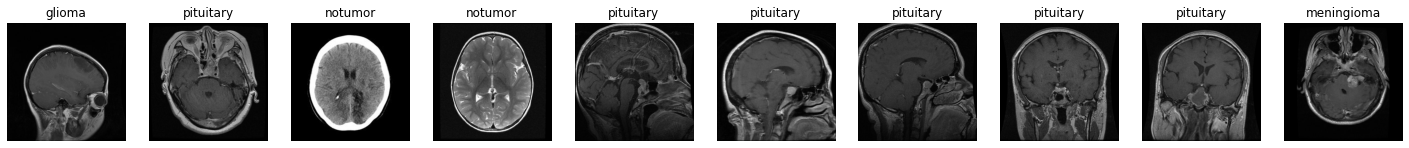

In [ ]:
# visualizing the random images in the dataset along with their labels
def sample_img(df,n):
    df = df.sample(n)
    plt.figure(figsize=(25, 25))
    for i,j in enumerate(df.iterrows()):
        plt.subplot(1,n,i+1)
        plt.imshow(j[1]['image'])
        plt.title("{}".format(j[1]['class'])) 
        plt.axis('off')
sample_img(df,10)

**Data Pre-processing**




The data generator is an iterator, returning batches of image samples from the directory when requested. We can configure the batch size and prepare the data generator and get batches of images by calling the **flow_from_directory()** function./

### Initialize ImageDataGenerator
- Train data generator
  - Rescale the images
  - Specify shear Intensity
  - Specify range for random zoom
  - Randomly flip inputs horizontally
- Test data generator
  - Rescale the images


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create data generator for training data with data augmentation and normalizing all values by 255
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)


test_datagen = ImageDataGenerator(rescale = 1./255)

### Training & testing data obtained from ImageDataGenerator using flow_from_directory
- Give directory path
- Give target size
- Give batch_size = n
- Specify class_mode = 'categorical'

In [ ]:
# Setting training data generator's source directory 
# Setting the target size to resize all the images to (128, 128)

training_set = train_datagen.flow_from_directory('/content/Brain_tumor_data/Training',
                                                 target_size = (128, 128),
                                                 batch_size = 64,
                                                 class_mode = 'categorical') 

# Setting Validation data generator's source directory 
test_set = test_datagen.flow_from_directory('/content/Brain_tumor_data/Testing',
                                            target_size = (128, 128),
                                            batch_size = 64,
                                            class_mode = 'categorical') 


Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


## Transfer Learning

### VGG16

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

base_model = VGG16(input_shape=(128,128,3),
                   weights='imagenet',
                   include_top=False) #imports the VGG16 model and discards the last 1000 neuron layer.

x = base_model.output
x = GlobalAveragePooling2D()(x) # Optional
x = Dense(1024, activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x = Dense(512, activation='relu')(x) #dense layer 2
x = Dense(256, activation='relu')(x) #dense layer 3
preds = Dense(4, activation='softmax')(x) #final layer with softmax activation

model_vgg16 = Model(inputs=base_model.input,
                    outputs=preds)

# set the first 20 layers of the network to be non-trainable
for layer in model_vgg16.layers[:20]:
    layer.trainable=False
for layer in model_vgg16.layers[20:]:
    layer.trainable=True

# Compile the model
model_vgg16.compile(optimizer='Adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

model_vgg16.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                              

In [ ]:
vgg16_history = model_vgg16.fit(training_set, epochs = 30, validation_data = test_set) 

Epoch 1/30
90/90 [==============================] - 50s 408ms/step - loss: 0.7082 - accuracy: 0.7162 - val_loss: 0.5965 - val_accuracy: 0.7574
Epoch 2/30
90/90 [==============================] - 35s 388ms/step - loss: 0.4522 - accuracy: 0.8221 - val_loss: 0.5187 - val_accuracy: 0.8017
Epoch 3/30
90/90 [==============================] - 35s 388ms/step - loss: 0.4097 - accuracy: 0.8356 - val_loss: 0.6887 - val_accuracy: 0.7498
Epoch 4/30
90/90 [==============================] - 35s 384ms/step - loss: 0.3963 - accuracy: 0.8445 - val_loss: 0.6222 - val_accuracy: 0.7735
Epoch 5/30
90/90 [==============================] - 35s 388ms/step - loss: 0.3484 - accuracy: 0.8687 - val_loss: 0.3803 - val_accuracy: 0.8604
Epoch 6/30
90/90 [==============================] - 35s 388ms/step - loss: 0.3140 - accuracy: 0.8778 - val_loss: 0.3976 - val_accuracy: 0.8452
Epoch 7/30
90/90 [==============================] - 35s 390ms/step - loss: 0.3006 - accuracy: 0.8834 - val_loss: 0.3806 - val_accuracy: 0.8505

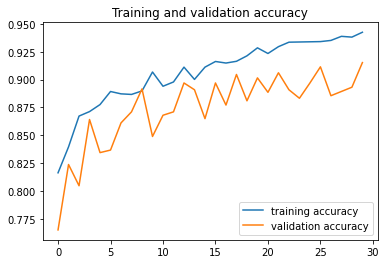

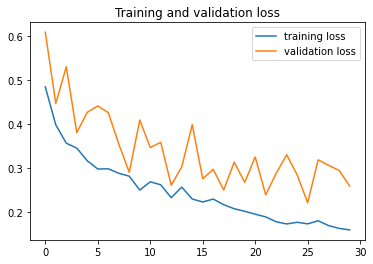

In [ ]:
## Accuracy and Loss plots

accuracy = vgg16_history.history['accuracy']
val_accuracy = vgg16_history.history['val_accuracy']
loss = vgg16_history.history['loss']
val_loss = vgg16_history.history['val_loss']

epochs = range(len(accuracy)) # Get number of epochs

plt.plot(epochs, accuracy, label = 'training accuracy')
plt.plot(epochs, val_accuracy, label = 'validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc = 'lower right')
plt.figure()

plt.plot(epochs, loss, label = 'training loss')
plt.plot(epochs, val_loss, label = 'validation loss')
plt.legend(loc = 'upper right')
plt.title ('Training and validation loss')
plt.show()

In [ ]:
# Saving model weights
model_vgg16.save('vgg16_1.h5')
model_vgg16.save_weights('vgg16_1_weights.h5')

### VGG19

In [ ]:
import tensorflow
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

base_model = VGG19(input_shape=(128,128,3),
                   weights='imagenet',
                   include_top=False) #imports the VGG16 model and discards the last 1000 neuron layer.

x = base_model.output
x = GlobalAveragePooling2D()(x) # Optional
x = Dense(1024, activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x = Dense(512, activation='relu')(x) #dense layer 2
x = Dense(256, activation='relu')(x) #dense layer 3
preds = Dense(4, activation='softmax')(x) #final layer with softmax activation

model_vgg19 = Model(inputs=base_model.input,
                    outputs=preds)

# set the first 20 layers of the network to be non-trainable
for layer in model_vgg19.layers[:20]:
    layer.trainable=False
for layer in model_vgg19.layers[20:]:
    layer.trainable=True

# Compile the model
model_vgg19.compile(optimizer='Adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

model_vgg19.summary()

80150528/80134624 [==============================] - 0s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                            

In [ ]:
vgg19_history = model_vgg19.fit(training_set, epochs = 30, validation_data = test_set) 

Epoch 1/30
90/90 [==============================] - 37s 393ms/step - loss: 0.6449 - accuracy: 0.7330 - val_loss: 0.5367 - val_accuracy: 0.7895
Epoch 2/30
90/90 [==============================] - 36s 398ms/step - loss: 0.3871 - accuracy: 0.8543 - val_loss: 0.3873 - val_accuracy: 0.8452
Epoch 3/30
90/90 [==============================] - 35s 388ms/step - loss: 0.3327 - accuracy: 0.8766 - val_loss: 0.4199 - val_accuracy: 0.8322
Epoch 4/30
90/90 [==============================] - 35s 385ms/step - loss: 0.3047 - accuracy: 0.8799 - val_loss: 0.3425 - val_accuracy: 0.8673
Epoch 5/30
90/90 [==============================] - 35s 386ms/step - loss: 0.2521 - accuracy: 0.9081 - val_loss: 0.3266 - val_accuracy: 0.8711
Epoch 6/30
90/90 [==============================] - 35s 387ms/step - loss: 0.2172 - accuracy: 0.9175 - val_loss: 0.3197 - val_accuracy: 0.8940
Epoch 7/30
90/90 [==============================] - 35s 385ms/step - loss: 0.2065 - accuracy: 0.9212 - val_loss: 0.3484 - val_accuracy: 0.8856

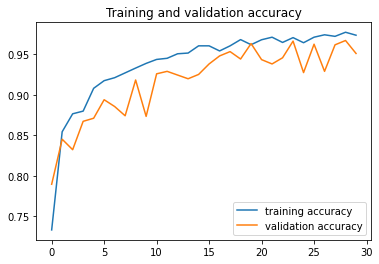

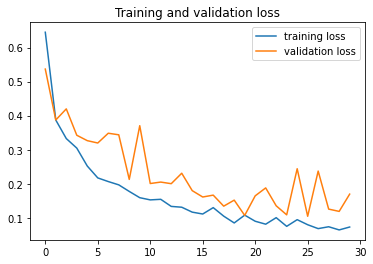

In [ ]:
## Accuracy and Loss plots

accuracy = vgg19_history.history['accuracy']
val_accuracy = vgg19_history.history['val_accuracy']
loss = vgg19_history.history['loss']
val_loss = vgg19_history.history['val_loss']

epochs = range(len(accuracy)) # Get number of epochs

plt.plot(epochs, accuracy, label = 'training accuracy')
plt.plot(epochs, val_accuracy, label = 'validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc = 'lower right')
plt.figure()

plt.plot(epochs, loss, label = 'training loss')
plt.plot(epochs, val_loss, label = 'validation loss')
plt.legend(loc = 'upper right')
plt.title ('Training and validation loss')
plt.show()

In [ ]:
# Saving model weights
model_vgg19.save('vgg19.h5')
model_vgg19.save_weights('vgg19_weights.h5')

### MobileNet

In [ ]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model

base_model = MobileNet(input_shape=(128,128,3),
                       weights='imagenet',
                       include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.

x = base_model.output
x = GlobalAveragePooling2D()(x) # Optional
x = Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(512,activation='relu')(x) #dense layer 2
x = Dense(256,activation='relu')(x) #dense layer 3
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
preds = Dense(4,activation='softmax')(x) #final layer with softmax activation

model_mobilenet = Model(inputs=base_model.input,
                        outputs=preds)

# set the first 20 layers of the network to be non-trainable
for layer in model_mobilenet.layers[:20]:
    layer.trainable=False
for layer in model_mobilenet.layers[20:]:
    layer.trainable=True

# Compile the model
model_mobilenet.compile(optimizer='Adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

model_mobilenet.summary()

17235968/17225924 [==============================] - 0s 0us/step
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 64, 64, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 64, 64, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 64, 64, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 64, 64, 32)       128  

In [ ]:
mobilenet_history = model_mobilenet.fit(training_set, epochs = 50, validation_data = test_set) 

Epoch 1/50
90/90 [==============================] - 37s 375ms/step - loss: 0.5099 - accuracy: 0.8274 - val_loss: 0.7089 - val_accuracy: 0.8230
Epoch 2/50
90/90 [==============================] - 33s 366ms/step - loss: 0.2043 - accuracy: 0.9301 - val_loss: 1.3290 - val_accuracy: 0.7590
Epoch 3/50
90/90 [==============================] - 34s 380ms/step - loss: 0.1456 - accuracy: 0.9503 - val_loss: 0.5520 - val_accuracy: 0.8642
Epoch 4/50
90/90 [==============================] - 33s 366ms/step - loss: 0.1227 - accuracy: 0.9615 - val_loss: 0.2001 - val_accuracy: 0.9390
Epoch 5/50
90/90 [==============================] - 33s 367ms/step - loss: 0.0949 - accuracy: 0.9685 - val_loss: 0.1440 - val_accuracy: 0.9596
Epoch 6/50
90/90 [==============================] - 33s 367ms/step - loss: 0.0783 - accuracy: 0.9704 - val_loss: 0.2368 - val_accuracy: 0.9222
Epoch 7/50
90/90 [==============================] - 33s 368ms/step - loss: 0.0741 - accuracy: 0.9765 - val_loss: 0.0916 - val_accuracy: 0.9703

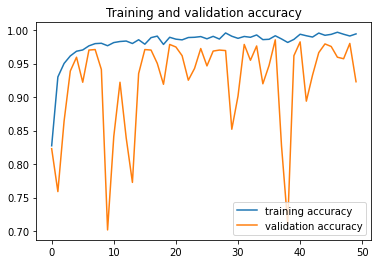

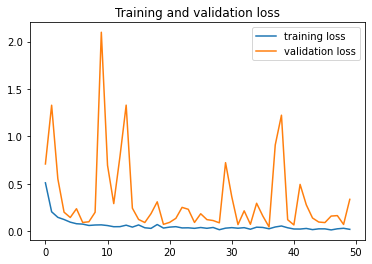

In [ ]:
## Accuracy and Loss plots

accuracy = mobilenet_history.history['accuracy']
val_accuracy = mobilenet_history.history['val_accuracy']
loss = mobilenet_history.history['loss']
val_loss = mobilenet_history.history['val_loss']

epochs = range(len(accuracy)) # Get number of epochs

plt.plot(epochs, accuracy, label = 'training accuracy')
plt.plot(epochs, val_accuracy, label = 'validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc = 'lower right')
plt.figure()

plt.plot(epochs, loss, label = 'training loss')
plt.plot(epochs, val_loss, label = 'validation loss')
plt.legend(loc = 'upper right')
plt.title ('Training and validation loss')
plt.show()

In [ ]:
# Saving model and its weights for future use
model_mobilenet.save('mobilenet.h5')
model_mobilenet.save_weights('mobilenet_weights.h5')

### ResNet50


In [ ]:
import tensorflow
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model

base_model = ResNet50V2(input_shape=(128, 128 ,3),
                      weights='imagenet',
                      include_top=False) #imports the ResNet50 model and discards the last 1000 neuron layer.

x = base_model.output
x = GlobalAveragePooling2D()(x) 
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x) 
x = Dense(128, activation='relu')(x) 
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
preds = Dense(4, activation='softmax')(x) 

model_resnet50 = Model(inputs=base_model.input, outputs=preds)

# set the first 150 layers of the network to be non-trainable
for layer in model_resnet50.layers[:150]:
    layer.trainable=False
for layer in model_resnet50.layers[150:]:
    layer.trainable=True

# Compile the model
model_resnet50.compile(optimizer=tensorflow.optimizers.Adam(learning_rate=1e-5),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

model_resnet50.summary()

94683136/94668760 [==============================] - 1s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D) 

In [ ]:
resnet50_history = model_resnet50.fit(training_set, epochs = 50, validation_data = test_set) 

Epoch 1/50
90/90 [==============================] - 41s 393ms/step - loss: 1.7921 - accuracy: 0.3796 - val_loss: 1.1695 - val_accuracy: 0.5416
Epoch 2/50
90/90 [==============================] - 34s 372ms/step - loss: 1.2081 - accuracy: 0.5655 - val_loss: 0.8699 - val_accuracy: 0.6804
Epoch 3/50
90/90 [==============================] - 34s 373ms/step - loss: 0.9407 - accuracy: 0.6549 - val_loss: 0.7167 - val_accuracy: 0.7269
Epoch 4/50
90/90 [==============================] - 35s 386ms/step - loss: 0.7558 - accuracy: 0.7264 - val_loss: 0.6340 - val_accuracy: 0.7567
Epoch 5/50
90/90 [==============================] - 34s 373ms/step - loss: 0.6475 - accuracy: 0.7586 - val_loss: 0.5573 - val_accuracy: 0.7788
Epoch 6/50
90/90 [==============================] - 34s 372ms/step - loss: 0.6059 - accuracy: 0.7847 - val_loss: 0.5008 - val_accuracy: 0.8047
Epoch 7/50
90/90 [==============================] - 34s 372ms/step - loss: 0.5272 - accuracy: 0.8107 - val_loss: 0.4600 - val_accuracy: 0.8246

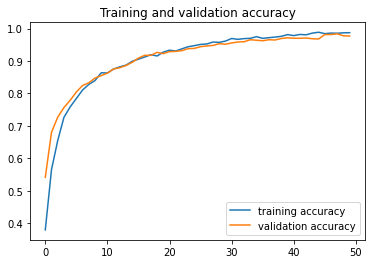

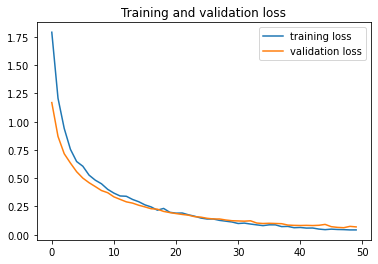

In [ ]:
## Accuracy and Loss plots

accuracy = resnet50_history.history['accuracy']
val_accuracy = resnet50_history.history['val_accuracy']
loss = resnet50_history.history['loss']
val_loss = resnet50_history.history['val_loss']

epochs = range(len(accuracy)) # Get number of epochs

plt.plot(epochs, accuracy, label = 'training accuracy')
plt.plot(epochs, val_accuracy, label = 'validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc = 'lower right')
plt.figure()

plt.plot(epochs, loss, label = 'training loss')
plt.plot(epochs, val_loss, label = 'validation loss')
plt.legend(loc = 'upper right')
plt.title ('Training and validation loss')
plt.show()

In [ ]:
# Saving model and its weights for future use
model_resnet50.save('resnet50.h5')
model_resnet50.save_weights('resnet50_weights.h5')

## Conclusion

- From the results we can conclude that RESNET50 outperformed all the other models by giving us a balanced results for training and testing above ~98%. So, we can use RESNET50 for doing further predictions, for early detection, classification of brain tumors to improve health diagnosis and provide impactful solutions

## Loading the best fit model and doing the predictions

In [ ]:
from tensorflow.keras.models import load_model

# Loading resnet50
model_resnet50 = load_model('resnet50.h5')



Softmax Outputs: [[9.99938130e-01 4.46136728e-05 5.24406414e-06 1.20469485e-05]]


Predicted_Label: glioma


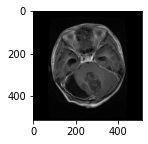

In [ ]:
plt.figure(figsize=[2, 2])

test_image = cv2.imread('/content/Brain_tumor_data/Testing/glioma/Te-glTr_0000.jpg')
plt.imshow(test_image)

# Resize the image to 128X128 shape to be compatible with the model
test_image = cv2.resize(test_image,(128,128))

# If not compatible expand the dimensions to match with the Keras Input
test_image = np.expand_dims(test_image, axis = 0)
test_image = test_image*1/255.0

# Predict the result of the test image
y_pred = model_resnet50.predict(test_image)
print('\n')
print("Softmax Outputs:",y_pred)

# Convert the predicted probabilities to labels
labels = ['glioma','meningioma','notumor','pituitary'] ## This i sthe order in which the dataset is read
for i in y_pred:
    for j, k in enumerate(i):
        if k == y_pred.max():
            print('\n')
            print('Predicted_Label:', labels[j])

In [ ]:
np.argmax(y_pred)

0

The image belongs to Class Glioma. 

The labels are as below

- glioma: 0 
- meningioma:1 
- notumor:2 
- pituitary:3